### Try 1. Simple use of rubert-tiny2

In [ ]:
import pandas as pd
import numpy as np
import json
import math

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_

from peft import LoraConfig, TaskType, get_peft_model

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from datasets import Dataset, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer, TrainerCallback, TrainingArguments, BertForSequenceClassification, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

BASE_MODEL = "cointegrated/rubert-tiny2"

# Let's name the classes 0, 1, 2 like their indices
id2label = {0: 'negative', 1: 'neutral', 2: 'positive'}
label2id = {'negative': 0, 'neutral': 1, 'positive': 2}

In [ ]:
df = pd.read_parquet('../comp_final_5years.parquet')

In [ ]:
p = 0.05

q_l = df.price_diff_percent.quantile(p)
q_u = df.price_diff_percent.quantile(1-p)

df['price_diff_cat'] = 1
df.loc[df['price_diff_percent'] <= q_l, 'price_diff_cat'] = 0
df.loc[df['price_diff_percent'] >= q_u, 'price_diff_cat'] = 2

df[['price_diff_cat']].groupby('price_diff_cat').value_counts()

price_diff_cat
0     3018
1    44255
2     3018
dtype: int64

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, id2label=id2label, label2id=label2id)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df.body.values,
                                                  df.price_diff_cat.values,
                                                  test_size=0.15,
                                                  random_state=42,
                                                  stratify=df.price_diff_cat.values)

In [ ]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=512, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

In [ ]:
train_input_ids, train_att_masks = encode(X_train.tolist())
valid_input_ids, valid_att_masks = encode(X_val.tolist())

In [ ]:
train_y = torch.LongTensor(y_train.tolist())
valid_y = torch.LongTensor(y_val.tolist())
train_y.size(),valid_y.size()

(torch.Size([42747]), torch.Size([7544]))

In [ ]:
BATCH_SIZE = 32
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

In [ ]:
N_labels = 3
model = BertForSequenceClassification.from_pretrained(BASE_MODEL,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
EPOCHS = 3
LEARNING_RATE = 2e-5

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer,
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS)

In [ ]:
train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)
        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()

            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))

    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(X_train) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(X_val) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/1336 [00:00<?, ?it/s]

Validation:   0%|          | 0/236 [00:00<?, ?it/s]

1336/1336 train loss: 0.4015894764699711 
236/236 val loss: 0.3833767468330719 
Epoch:  2


Training:   0%|          | 0/1336 [00:00<?, ?it/s]

Validation:   0%|          | 0/236 [00:00<?, ?it/s]

1336/1336 train loss: 0.37373005808470494 
236/236 val loss: 0.3772634338524382 
Epoch:  3


Training:   0%|          | 0/1336 [00:00<?, ?it/s]

Validation:   0%|          | 0/236 [00:00<?, ?it/s]

1336/1336 train loss: 0.3597352048772538 
236/236 val loss: 0.37873715626359994 


In [ ]:
label_names = ['negative', 'neutral', 'positive']

In [ ]:
print('classifiation report')
print(classification_report(valid_pred, y_val, target_names=label_names))

classifiation report
              precision    recall  f1-score   support

    negative       0.01      0.21      0.02        19
     neutral       1.00      0.90      0.95      7518
    positive       0.01      0.29      0.01         7

    accuracy                           0.90      7544
   macro avg       0.34      0.47      0.33      7544
weighted avg       1.00      0.90      0.94      7544



In [ ]:
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

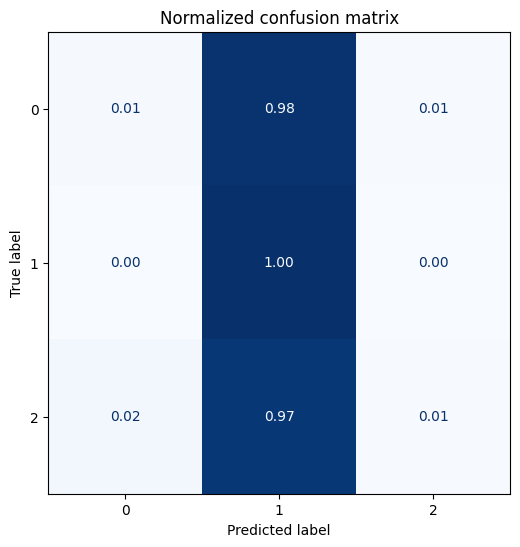

In [ ]:
plot_confusion_matrix(valid_pred, y_val)

**Experiment results:**
 - We can clearly see that unweighted tiny-BERT can not see anything from positive or negative classes, thus, quality is rather bad

### Try 2. Add weights in loss function

In [4]:
N_labels = 3
model = BertForSequenceClassification.from_pretrained(BASE_MODEL,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = model.cuda()


In [ ]:
EPOCHS = 3
LEARNING_RATE = 2e-5

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer,
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS)

In [ ]:
train_loss_per_epoch = []
val_loss_per_epoch = []
weight = torch.tensor([1.0, 0.05, 1.0])
weight = weight.to('cuda')

for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)
        logits = output['logits']
        criterion = torch.nn.CrossEntropyLoss(weight=weight)
        loss = criterion(logits, labels)
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            logits = output['logits']
            criterion = torch.nn.CrossEntropyLoss(weight=weight)
            loss = criterion(logits, labels)
            valid_loss += loss.item()

            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))

    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(X_train) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(X_val) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/1336 [00:00<?, ?it/s]

Validation:   0%|          | 0/236 [00:00<?, ?it/s]

1336/1336 train loss: 1.0681697476409866 
236/236 val loss: 1.079133947016829 
Epoch:  2


Training:   0%|          | 0/1336 [00:00<?, ?it/s]

Validation:   0%|          | 0/236 [00:00<?, ?it/s]

1336/1336 train loss: 1.0209926704089798 
236/236 val loss: 1.0584917194762473 
Epoch:  3


Training:   0%|          | 0/1336 [00:00<?, ?it/s]

Validation:   0%|          | 0/236 [00:00<?, ?it/s]

1336/1336 train loss: 0.977589787123446 
236/236 val loss: 1.0500506437936072 


In [ ]:
print('classifiation report')
print(classification_report(valid_pred, y_val, target_names=label_names))

classifiation report
              precision    recall  f1-score   support

    negative       0.29      0.12      0.17       902
     neutral       0.73      0.93      0.82      5306
    positive       0.32      0.09      0.14      1336

    accuracy                           0.69      7544
   macro avg       0.45      0.38      0.38      7544
weighted avg       0.60      0.69      0.62      7544



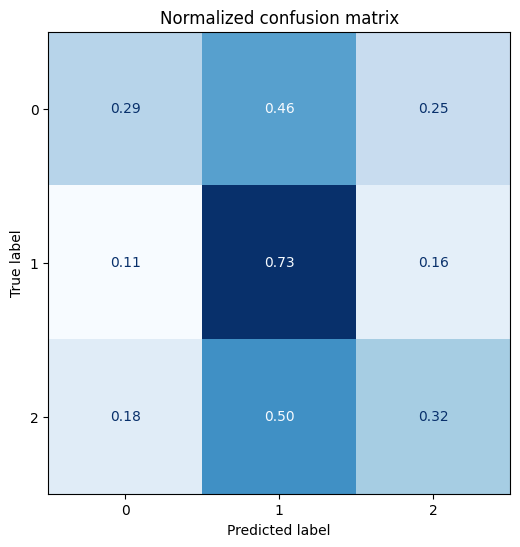

In [ ]:
plot_confusion_matrix(valid_pred, y_val)

**Experiment results:**
 - F1-macro increased, we see that some news were marked as positive or negative.

### Try 3. PEFT LoRA

In [3]:
N_labels = 3

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, r=1, lora_alpha=1, lora_dropout=0.1
)

model = BertForSequenceClassification.from_pretrained(BASE_MODEL,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model = get_peft_model(model, lora_config)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = model.cuda()

In [ ]:
EPOCHS = 20
LEARNING_RATE = 5e-3

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer,
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS)

In [ ]:
train_loss_per_epoch = []
val_loss_per_epoch = []
weight = torch.tensor([1.0, 0.05, 1.0])
weight = weight.to('cuda')

for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)
        logits = output['logits']
        criterion = torch.nn.CrossEntropyLoss(weight=weight)
        loss = criterion(logits, labels)
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            logits = output['logits']
            criterion = torch.nn.CrossEntropyLoss(weight=weight)
            loss = criterion(logits, labels)
            valid_loss += loss.item()

            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))

    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(X_train) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(X_val) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/1336 [00:00<?, ?it/s]

Validation:   0%|          | 0/236 [00:00<?, ?it/s]

1336/1336 train loss: 1.100815429302033 
236/236 val loss: 1.085436813154463 
Epoch:  2


Training:   0%|          | 0/1336 [00:00<?, ?it/s]

Validation:   0%|          | 0/236 [00:00<?, ?it/s]

1336/1336 train loss: 1.0996474918134198 
236/236 val loss: 1.099222070837425 
Epoch:  3


Training:   0%|          | 0/1336 [00:00<?, ?it/s]

Validation:   0%|          | 0/236 [00:00<?, ?it/s]

1336/1336 train loss: 1.09839723892733 
236/236 val loss: 1.0964025746462709 
Epoch:  4


Training:   0%|          | 0/1336 [00:00<?, ?it/s]

Validation:   0%|          | 0/236 [00:00<?, ?it/s]

1336/1336 train loss: 1.0979995669986673 
236/236 val loss: 1.104321348465095 
Epoch:  5


Training:   0%|          | 0/1336 [00:00<?, ?it/s]

Validation:   0%|          | 0/236 [00:00<?, ?it/s]

1336/1336 train loss: 1.0971207418841515 
236/236 val loss: 1.0899274824029308 
Epoch:  6


Training:   0%|          | 0/1336 [00:00<?, ?it/s]

Validation:   0%|          | 0/236 [00:00<?, ?it/s]

1336/1336 train loss: 1.094935977798022 
236/236 val loss: 1.0872722086259874 
Epoch:  7


Training:   0%|          | 0/1336 [00:00<?, ?it/s]

Validation:   0%|          | 0/236 [00:00<?, ?it/s]

1336/1336 train loss: 1.0923846853885821 
236/236 val loss: 1.0874446074841386 
Epoch:  8


Training:   0%|          | 0/1336 [00:00<?, ?it/s]

Validation:   0%|          | 0/236 [00:00<?, ?it/s]

1336/1336 train loss: 1.0894217546471578 
236/236 val loss: 1.0820578003333787 
Epoch:  9


Training:   0%|          | 0/1336 [00:00<?, ?it/s]

Validation:   0%|          | 0/236 [00:00<?, ?it/s]

1336/1336 train loss: 1.0883221885044418 
236/236 val loss: 1.0824688518956556 
Epoch:  10


Training:   0%|          | 0/1336 [00:00<?, ?it/s]

Validation:   0%|          | 0/236 [00:00<?, ?it/s]

1336/1336 train loss: 1.0807683269777697 
236/236 val loss: 1.0794519996744092 
Epoch:  11


Training:   0%|          | 0/1336 [00:00<?, ?it/s]

Validation:   0%|          | 0/236 [00:00<?, ?it/s]

1336/1336 train loss: 1.0797388615187056 
236/236 val loss: 1.0779108187909854 
Epoch:  12


Training:   0%|          | 0/1336 [00:00<?, ?it/s]

Validation:   0%|          | 0/236 [00:00<?, ?it/s]

1336/1336 train loss: 1.0757840772767266 
236/236 val loss: 1.0742019159814058 
Epoch:  13


Training:   0%|          | 0/1336 [00:00<?, ?it/s]

Validation:   0%|          | 0/236 [00:00<?, ?it/s]

1336/1336 train loss: 1.0746855033104292 
236/236 val loss: 1.0791866976325795 
Epoch:  14


Training:   0%|          | 0/1336 [00:00<?, ?it/s]

Validation:   0%|          | 0/236 [00:00<?, ?it/s]

1336/1336 train loss: 1.071652524396331 
236/236 val loss: 1.0739048883571463 
Epoch:  15


Training:   0%|          | 0/1336 [00:00<?, ?it/s]

Validation:   0%|          | 0/236 [00:00<?, ?it/s]

1336/1336 train loss: 1.0684036205182532 
236/236 val loss: 1.0759580031795017 
Epoch:  16


Training:   0%|          | 0/1336 [00:00<?, ?it/s]

Validation:   0%|          | 0/236 [00:00<?, ?it/s]

1336/1336 train loss: 1.0649046513313305 
236/236 val loss: 1.0779776866153135 
Epoch:  17


Training:   0%|          | 0/1336 [00:00<?, ?it/s]

Validation:   0%|          | 0/236 [00:00<?, ?it/s]

1336/1336 train loss: 1.0603042459059617 
236/236 val loss: 1.0759833811198252 
Epoch:  18


Training:   0%|          | 0/1336 [00:00<?, ?it/s]

Validation:   0%|          | 0/236 [00:00<?, ?it/s]

1336/1336 train loss: 1.0597574535065781 
236/236 val loss: 1.077599109481957 
Epoch:  19


Training:   0%|          | 0/1336 [00:00<?, ?it/s]

Validation:   0%|          | 0/236 [00:00<?, ?it/s]

1336/1336 train loss: 1.0533739517548841 
236/236 val loss: 1.0927445143461227 
Epoch:  20


Training:   0%|          | 0/1336 [00:00<?, ?it/s]

Validation:   0%|          | 0/236 [00:00<?, ?it/s]

1336/1336 train loss: 1.0526932909370896 
236/236 val loss: 1.0939496722766908 


In [ ]:
label_names = ['negative', 'neutral', 'positive']

In [ ]:
print('classifiation report')
print(classification_report(valid_pred, y_val, target_names=label_names))

classifiation report
              precision    recall  f1-score   support

    negative       0.23      0.07      0.10      1340
     neutral       0.60      0.93      0.73      4403
    positive       0.34      0.07      0.12      1801

    accuracy                           0.57      7544
   macro avg       0.39      0.36      0.32      7544
weighted avg       0.47      0.57      0.47      7544



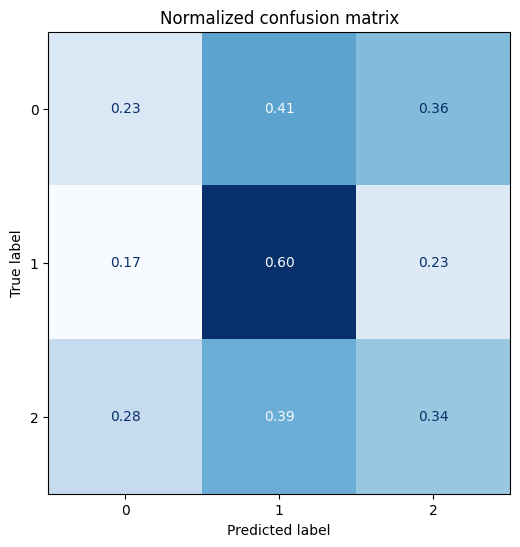

In [ ]:
plot_confusion_matrix(valid_pred, y_val)

**Experiment results:**
 - Model was unable to learn in 20 epochs. It missed in every class with pretty high probability. Only neutral class was predicted not that bad.

### Try 4. IMOEX with weights

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/glob_final_5years.parquet')

In [ ]:
df_imoex = df[['body', 'imoex_price_diff_percent']]

In [ ]:
df_imoex = df_imoex.dropna()

In [ ]:
df_imoex = df_imoex.rename(columns={'imoex_price_diff_percent': 'price_diff_percent'})

In [ ]:
p = 0.05

q_l = df_imoex.price_diff_percent.quantile(p)
q_u = df_imoex.price_diff_percent.quantile(1-p)

df_imoex['price_diff_cat'] = 1
df_imoex.loc[df_imoex['price_diff_percent'] <= q_l, 'price_diff_cat'] = 0
df_imoex.loc[df_imoex['price_diff_percent'] >= q_u, 'price_diff_cat'] = 2

df_imoex[['price_diff_cat']].groupby('price_diff_cat').value_counts()

price_diff_cat
0     3835
1    69028
2     3835
dtype: int64

In [ ]:
print(q_l, q_u)

-0.39032282630998383 0.36533449774359444


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, id2label=id2label, label2id=label2id)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_imoex.body.values,
                                                  df_imoex.price_diff_cat.values,
                                                  test_size=0.15,
                                                  random_state=42,
                                                  stratify=df_imoex.price_diff_cat.values)

In [ ]:
train_input_ids, train_att_masks = encode(X_train.tolist())
valid_input_ids, valid_att_masks = encode(X_val.tolist())

In [ ]:
train_y = torch.LongTensor(y_train.tolist())
valid_y = torch.LongTensor(y_val.tolist())
train_y.size(),valid_y.size()

(torch.Size([65193]), torch.Size([11505]))

In [ ]:
BATCH_SIZE = 32
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

In [2]:
N_labels = 3
model = BertForSequenceClassification.from_pretrained(BASE_MODEL,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = model.cuda()


In [ ]:
EPOCHS = 3
LEARNING_RATE = 2e-5

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer,
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS)

In [ ]:
train_loss_per_epoch = []
val_loss_per_epoch = []
weight = torch.tensor([1.0, 0.05, 1.0])
weight = weight.to('cuda')

for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)
        logits = output['logits']
        criterion = torch.nn.CrossEntropyLoss(weight=weight)
        loss = criterion(logits, labels)
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            logits = output['logits']
            criterion = torch.nn.CrossEntropyLoss(weight=weight)
            loss = criterion(logits, labels)
            valid_loss += loss.item()

            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))

    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(X_train) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(X_val) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/2038 [00:00<?, ?it/s]

Validation:   0%|          | 0/360 [00:00<?, ?it/s]

2038/2038 train loss: 1.0882536176376418 
360/360 val loss: 1.0667869493365287 
Epoch:  2


Training:   0%|          | 0/2038 [00:00<?, ?it/s]

Validation:   0%|          | 0/360 [00:00<?, ?it/s]

2038/2038 train loss: 1.047499815164768 
360/360 val loss: 1.0575308817956182 
Epoch:  3


Training:   0%|          | 0/2038 [00:00<?, ?it/s]

Validation:   0%|          | 0/360 [00:00<?, ?it/s]

2038/2038 train loss: 1.009669255724833 
360/360 val loss: 1.0656349271535874 


In [ ]:
label_names = ['negative', 'neutral', 'positive']

In [ ]:
print('classifiation report')
print(classification_report(valid_pred, y_val, target_names=label_names))

classifiation report
              precision    recall  f1-score   support

    negative       0.26      0.10      0.14      1529
     neutral       0.68      0.94      0.79      7507
    positive       0.35      0.08      0.13      2469

    accuracy                           0.64     11505
   macro avg       0.43      0.37      0.35     11505
weighted avg       0.55      0.64      0.56     11505



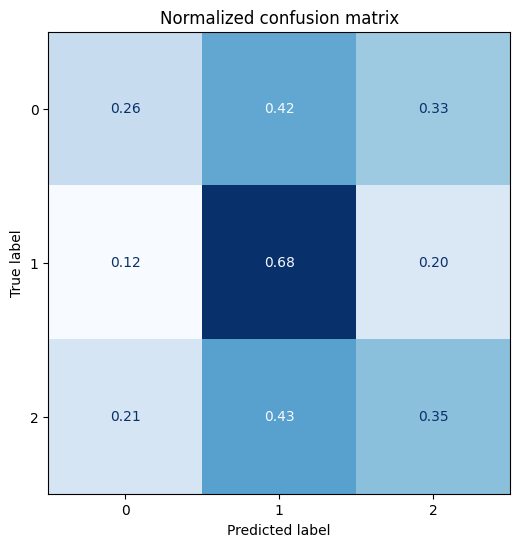

In [ ]:
plot_confusion_matrix(valid_pred, y_val)

**Experiment results:**
 - Poor result. Probably due to very small effect of individual news on all companies in index.

### Try 5. Drop long news source and select only news with high absolute change as positive or negative

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/comp_final_5years.parquet')

In [ ]:
df = df.drop(df[df['website'] == 'Kommersant'].index)

In [ ]:
p = 0.0125

q_l = df.price_diff_percent.quantile(p)
q_u = df.price_diff_percent.quantile(1-p)

df['price_diff_cat'] = 1
df.loc[df['price_diff_percent'] <= q_l, 'price_diff_cat'] = 0
df.loc[df['price_diff_percent'] >= q_u, 'price_diff_cat'] = 2

df[['price_diff_cat']].groupby('price_diff_cat').value_counts()

price_diff_cat
0      586
1    45632
2      586
dtype: int64

In [ ]:
q_l

-1.568159121543968

In [ ]:
q_u

1.5762573809561138

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, id2label=id2label, label2id=label2id)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df.body.values,
                                                  df.price_diff_cat.values,
                                                  test_size=0.15,
                                                  random_state=42,
                                                  stratify=df.price_diff_cat.values)

In [ ]:
train_input_ids, train_att_masks = encode(X_train.tolist())
valid_input_ids, valid_att_masks = encode(X_val.tolist())

In [ ]:
train_y = torch.LongTensor(y_train.tolist())
valid_y = torch.LongTensor(y_val.tolist())
train_y.size(),valid_y.size()

(torch.Size([39783]), torch.Size([7021]))

In [ ]:
BATCH_SIZE = 32
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

In [1]:
N_labels = 3
model = BertForSequenceClassification.from_pretrained(BASE_MODEL,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = model.cuda()

In [ ]:
EPOCHS = 3
LEARNING_RATE = 2e-5

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer,
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS)

In [ ]:
train_loss_per_epoch = []
val_loss_per_epoch = []
weight = torch.tensor([1.0, 0.0125, 1.0])
weight = weight.to('cuda')

for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)
        logits = output['logits']
        criterion = torch.nn.CrossEntropyLoss(weight=weight)
        loss = criterion(logits, labels)
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            logits = output['logits']
            criterion = torch.nn.CrossEntropyLoss(weight=weight)
            loss = criterion(logits, labels)
            valid_loss += loss.item()

            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))

    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(X_train) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(X_val) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/1244 [00:00<?, ?it/s]

Validation:   0%|          | 0/220 [00:00<?, ?it/s]

1244/1244 train loss: 1.181728286938173 
220/220 val loss: 1.1578543058850548 
Epoch:  2


Training:   0%|          | 0/1244 [00:00<?, ?it/s]

Validation:   0%|          | 0/220 [00:00<?, ?it/s]

1244/1244 train loss: 1.0443465071535667 
220/220 val loss: 1.073364989391782 
Epoch:  3


Training:   0%|          | 0/1244 [00:00<?, ?it/s]

Validation:   0%|          | 0/220 [00:00<?, ?it/s]

1244/1244 train loss: 0.9735870708642569 
220/220 val loss: 1.033924017304724 


In [ ]:
label_names = ['negative', 'neutral', 'positive']

In [ ]:
print('classifiation report')
print(classification_report(valid_pred, y_val, target_names=label_names))

classifiation report
              precision    recall  f1-score   support

    negative       0.10      0.09      0.10        97
     neutral       0.99      0.98      0.98      6899
    positive       0.05      0.16      0.07        25

    accuracy                           0.96      7021
   macro avg       0.38      0.41      0.38      7021
weighted avg       0.97      0.96      0.97      7021



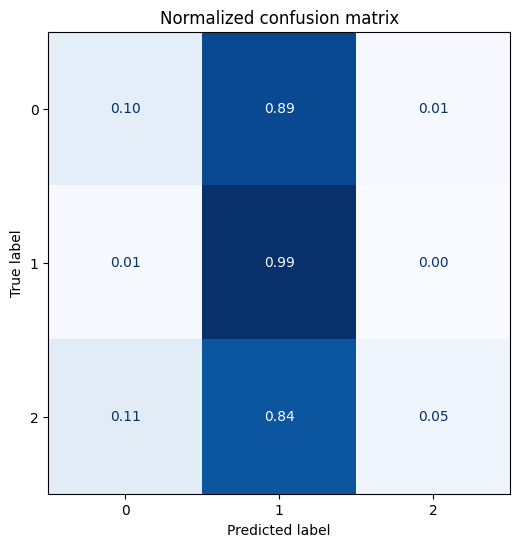

In [ ]:
plot_confusion_matrix(valid_pred, y_val)

**Experiment results:**
 - Almost no change to simple one. But F1 macro score is higher due to less data in two not neutral classes.